In [1]:
#importando as bibliotecas
import pandas as pd
import numpy as np
import datetime
from matplotlib import pyplot as plt
import seaborn as sns
import requests
from io import StringIO

C:\Users\dev_user\AppData\Local\Continuum\anaconda3\lib\site-packages\statsmodels\tools\_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


In [82]:
## Carregar arquivo direto do Google Drive

orig_url='https://drive.google.com/file/d/1_KyiFs1f7MIRrrxYdzw_Xk2bybwQwnXu/view?usp=sharing'

file_id = orig_url.split('/')[-2]
dwn_url='https://drive.google.com/uc?export=download&id=' + file_id
url = requests.get(dwn_url).text
csv_raw = StringIO(url)
df_consultas = pd.read_csv(csv_raw)
df_consultas.head()

,PatientId,AppointmentID,Gender,ScheduledDay,AppointmentDay,Age,Neighbourhood,Scholarship,Hipertension,Diabetes,Alcoholism,Handcap,SMS_received,No-show
0,2.987250e+13,5642903,F,2016-04-29T18:38:08Z,2016-04-29T00:00:00Z,62,JARDIM DA PENHA,0,1,0,0,0,0,No
1,5.589978e+14,5642503,M,2016-04-29T16:08:27Z,2016-04-29T00:00:00Z,56,JARDIM DA PENHA,0,0,0,0,0,0,No
2,4.262962e+12,5642549,F,2016-04-29T16:19:04Z,2016-04-29T00:00:00Z,62,MATA DA PRAIA,0,0,0,0,0,0,No
3,8.679512e+11,5642828,F,2016-04-29T17:29:31Z,2016-04-29T00:00:00Z,8,PONTAL DE CAMBURI,0,0,0,0,0,0,No
4,8.841186e+12,5642494,F,2016-04-29T16:07:23Z,2016-04-29T00:00:00Z,56,JARDIM DA PENHA,0,1,1,0,0,0,No


In [83]:
## Qual é a idade média dos pacientes?
df_consultas['Age'].mean()

37.08887421173107

In [84]:
## Qual é a proporção aproximada de pacientes que compareceram à consulta?
df_consultas['No-show'].value_counts('No').to_dict()

{'No': 0.798067440534892, 'Yes': 0.20193255946510807}

In [85]:
## Qual é a menor e maior idade, respectivamente, presente no dataset?
print('Menor idade :',df_consultas['Age'].min())
print('Maior idade :',df_consultas['Age'].max())

## Idade -1 não existe, considerar ou não informação na base? Na resposta considerei 0 ""-1"
print('Menor idade sem negativo :',df_consultas['Age'][df_consultas['Age']>=0].min())

Menor idade : -1
Maior idade : 115
Menor idade sem negativo : 0


In [98]:
### aplicando mesma transformação na base que o professor

#criando uma nova coluna -> Tempo de espera (diferença entre a data em que a consulta foi agendada e o dia da consulta)
df_consultas.ScheduledDay=pd.to_datetime(df_consultas.ScheduledDay)  #transformando as colunas par o tipo datetime
df_consultas.AppointmentDay=pd.to_datetime(df_consultas.AppointmentDay)

#Encontra a diferença entre o momento da marcação da consulta e o dia da consulta
tempo_espera=df_consultas.ScheduledDay-df_consultas.AppointmentDay

df_consultas['AwaitingTime']=tempo_espera.apply(lambda x: x.days) #transforma os valores em dias 

#Encontrando as idades negativas
df_consultas[df_consultas['Age'] < 0]['Age'].value_counts()

#filtrando apenas idades maiores que 0
df_consultas_filtrado=df_consultas[df_consultas['Age']>=0]


#transformando os tempo de espera para um valor não negativo
df_consultas_filtrado['AwaitingTime'] = df_consultas_filtrado['AwaitingTime'].apply(lambda x: abs(x))

#aplicando a transformação para os dados categóricos
categoricas=['Neighbourhood','Gender','No-show']
for coluna in categoricas:
  df_consultas_filtrado[coluna]=pd.Categorical(df_consultas_filtrado[coluna]).codes

C:\Users\dev_user\AppData\Local\Continuum\anaconda3\lib\site-packages\ipykernel_launcher.py:20: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
C:\Users\dev_user\AppData\Local\Continuum\anaconda3\lib\site-packages\ipykernel_launcher.py:25: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


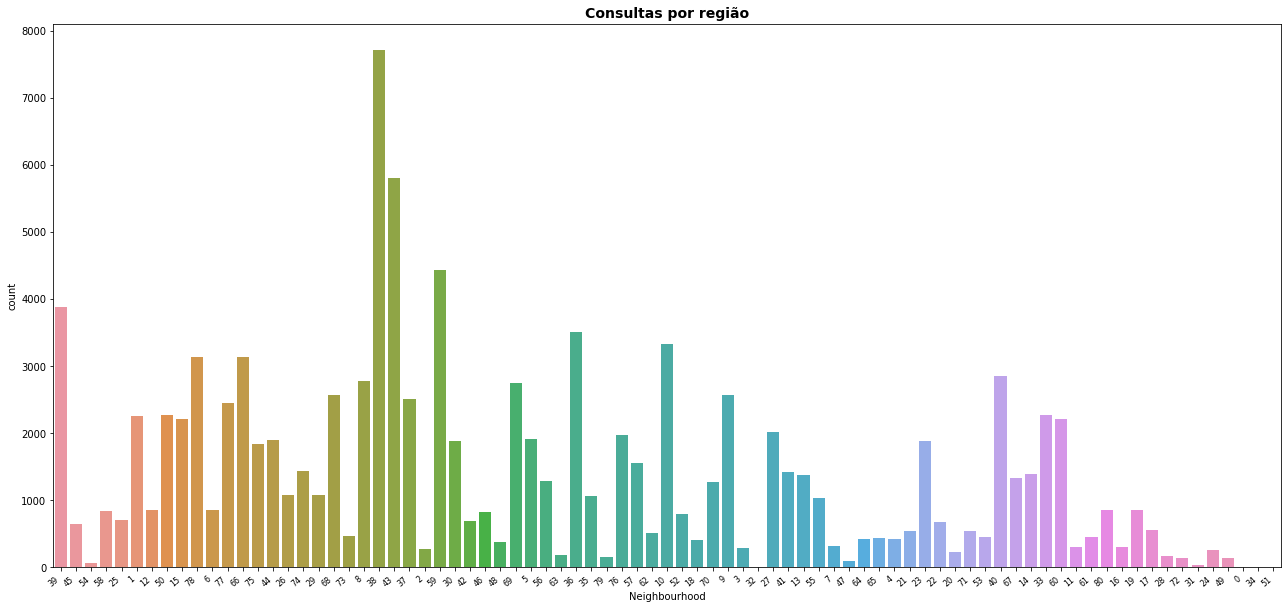

In [105]:
## Qual região possui o maior número de consultas marcadas?

#plotando o número de consultas por região 
regioes = df_consultas_filtrado['Neighbourhood'].unique()
plt.figure(figsize=(22,10))
ax = sns.countplot(x='Neighbourhood', data=df_consultas_filtrado, order=regioes)
ax.set_xticklabels(ax.get_xticklabels(), rotation=40, ha="right", fontsize=8)
plt.title('Consultas por região', fontsize=14, fontweight='bold')
plt.show()

In [36]:
## Qual foi o tipo de transformação dos dados categóricos realizado?

## Alterar categoria por número, na mesma variável (Label Encoding)

In [107]:
## Quantos valores diferentes encontramos para a variável dos SMS recebidos (SMS_received)?

df_consultas['SMS_received'].nunique()

2

In [108]:
## Em quantas localidades diferentes (Neighbourhood) os pacientes residem?
df_consultas['Neighbourhood'].nunique()

81

In [120]:
## Qual é a proporção de pacientes que receberam o sms e NÃO compareceram?
sms = df_consultas[df_consultas['SMS_received'] == 1].shape[0]
smsNoshow = df_consultas_filtrado[(df_consultas_filtrado['SMS_received'] == 1) & (df_consultas_filtrado['No-show'] == 1)].shape[0] 
smsNoshow / sms

0.27574544839637

In [122]:
## Criar modelo do professor

#selecionando os dados para a construção da previsão
entradas = ['Gender','Age','Neighbourhood','Scholarship','Hipertension','Diabetes','Alcoholism','SMS_received','AwaitingTime']
saida=['No-show']

x=df_consultas_filtrado[entradas]
y=df_consultas_filtrado[saida]

from sklearn.model_selection import train_test_split
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.3, random_state=1) 

#aplicando um modelo de classificação via árvore de decisão
from sklearn.tree import DecisionTreeClassifier
clf_arvore = DecisionTreeClassifier() 
clf_arvore.fit(x_train, y_train) 

#realiza a previsão com os dados
y_previsto = clf_arvore.predict(x_test) 

In [124]:
## Acurácia

from sklearn.metrics import accuracy_score
acuracia = accuracy_score(y_test, y_previsto)
print('Acurácia da àrvore de Decisão: ',acuracia)

#contrução da matriz de confusão
from sklearn.metrics import classification_report, confusion_matrix
matriz_confusao = confusion_matrix(y_test, y_previsto)
print(matriz_confusao)


Acurácia da àrvore de Decisão:  0.7340008444417637
[[22243  4242]
 [ 4578  2095]]


In [158]:
## Sobre a matriz de confusão para essa classificação, é CORRETO afirmar:
# Para os dados de teste existem mais instâncias da saída zero (0 - compareceram à consulta).
print('saida0 =', 22243 + 4242)
print('saida1 =', 4578 + 2095)

# Açternativa
y_test['No-show'].value_counts().to_dict()

saida0 = 26485
saida1 = 6673


{0: 26485, 1: 6673}

In [130]:
## Qual das colunas do dataset possuem valores nulos?
df_consultas.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 110527 entries, 0 to 110526
Data columns (total 15 columns):
 #   Column          Non-Null Count   Dtype              
---  ------          --------------   -----              
 0   PatientId       110527 non-null  float64            
 1   AppointmentID   110527 non-null  int64              
 2   Gender          110527 non-null  object             
 3   ScheduledDay    110527 non-null  datetime64[ns, UTC]
 4   AppointmentDay  110527 non-null  datetime64[ns, UTC]
 5   Age             110527 non-null  int64              
 6   Neighbourhood   110527 non-null  object             
 7   Scholarship     110527 non-null  int64              
 8   Hipertension    110527 non-null  int64              
 9   Diabetes        110527 non-null  int64              
 10  Alcoholism      110527 non-null  int64              
 11  Handcap         110527 non-null  int64              
 12  SMS_received    110527 non-null  int64              
 13  No-show       

In [148]:
## Comparando apenas a identificação do paciente (PatientId) com o número dos agendamentos das consultas (AppointmentID)
## o que podemos inferir?
print('valores únicos PatientId', df_consultas['PatientId'].nunique())
print('valores únicos AppointmentID', df_consultas['AppointmentID'].nunique())
print('Total de linhas', df_consultas.shape[0])

print('RESPOSTA: Campo AppointmentID possui valores únicos, PatientId não, o que levo a inferição de que existem pacientes que realizam mais de 1 atendimento.')

valores únicos PatientId 62299
valores únicos AppointmentID 110527
Total de linhas 110527
RESPOSTA: Campo AppointmentID possui valores únicos, PatientId não, o que levo a inferição de que existem pacientes que realizam mais de 1 atendimento.


In [153]:
## Quantas variáveis binárias (apenas dois valores) existem no dataset?
#contando a quantidade de valores distintos em cada uma das colunas
variaveis = 0
for colunas in list(df_consultas.columns):
  if df_consultas[colunas].nunique() == 2:
    variaveis = variaveis + 1
    print( "{0:25} {1}".format(colunas, df_consultas[colunas].nunique()))

print('Quantidade de variáveis binárias : ', variaveis)

Gender                    2
Scholarship               2
Hipertension              2
Diabetes                  2
Alcoholism                2
SMS_received              2
No-show                   2
Quantidade de variáveis binárias :  7


In [154]:
## Qual foi a acurácia obtida com a aplicação do modelo?
acuracia = accuracy_score(y_test, y_previsto)
print('Acurácia da àrvore de Decisão: ',acuracia)

Acurácia da àrvore de Decisão:  0.7340008444417637


In [79]:
## Quantas instâncias e atributos existem no dataset, respectivamente?
df_consultas.shape

(110527, 14)

In [162]:
## Sobre a matriz de confusão para os dados de teste, é correto afirmar, EXCETO:
# O desempennho do algoritmo para a previsão da classe 1 (não compareceu) é superior ao da classe 0 (compareceu).
# Mais de 6300 instâncias foram classificadas (previstas) como pertencentes à classe 1.
# Mais de 26000 instâncias de teste pertencem à classe 0 (compareceram à consulta).
# Aproximadamente, 80% dos dados são da classe 0 (compareceu).
TP = 22247
FP = 4592
TN = 2081
FN = 4238

print('Desempenho para a previsão da classe 1 =', TN / (TN + FP))
print('Desempenho para a previsão da classe 0 =', TP / (TP + FN))
print(TN + FP, 'instâncias foram classificadas (previstas) como pertencentes à classe 1', TP / (TP + FN))
print(TP + FN, 'instâncias foram classificadas (previstas) como pertencentes à classe 1', TP / (TP + FN))

Desempenho para a previsão da classe 1 = 0.3118537389479994
Desempenho para a previsão da classe 0 = 0.8399848971115725
6673 instâncias foram classificadas (previstas) como pertencentes à classe 1 0.8399848971115725
26485 instâncias foram classificadas (previstas) como pertencentes à classe 1 0.8399848971115725
